# Orbits 1: Orbits in Spherical Gravitational Potentials

Author(s): Adrian Price-Whelan


## Learning goals

The main goal for this tutorial is to introduce the concept of orbits and numerically-computed trajectories using spherical gravitational potential models.


## Introduction

TODO: 
- Here assuming Orbit = periodic! Real galaxies: more transient?! 
- Also mention that, if you need to compute your own orbits, fine to build your own framework, but fast tools exist, like Gala

For many contexts in Galactic dynamics, the orbital trajectory of an object (star, planet, star cluster, satellite galaxy, etc.) is a fundamental tool for studying and interpreting the dynamical state, evolution, or initial conditions of a gravitational system. However, in general, we cannot directly observe any appreciable changes in position or velocity of a gravitating body over human timescales. As Galactic dynamicists, we therefore effectively only have access to measurements of a single kinematic snapshot of any dynamical system. With a kinematic snapshot and a model for the overall mass distribution of a system, we then seek to compute the past or future trajectories of the constituent bodies and use this information to, for example, refine our mass model, interpret kinematic features, or predict the evolution (past or present) of a system. In many such regimes, the mass of the orbiting body is small relative to the larger mass distribution in which it orbits (e.g., a star within a Galaxy). It is therefore often sufficient to treat an orbiting body as an effectively massless "tracer" particle whose trajectory is set by the broader mass distribution, and which does not cause any appreciable backreaction of the host system. (In later workshops, we will explore cases in which this assumption breaks down, such as with the Milky Way–LMC interaction.) In this context, a common goal is to compute the time-dependent position and velocity — the orbit — of an effectively massless body orbiting within an external gravitational field.

While galaxies are actually composed of a large number of discrete point masses and structures (and we do not know the smallest size of dark matter substructures), it is often sufficient to model the mass distribution of a galaxy by considering smooth mass distributions (where the smoothing length scale is much smaller than the size of a galaxy, <<100 kpc, but larger than the spacing between massive structures, >>1 pc). As we saw in the lectures, and as you might recall from past Mechanics courses, the fundamental quantity in the context of computing orbits is the acceleration field $\boldsymbol{a}(\boldsymbol{x})$ specified often as a function of a three-dimensional position $\boldsymbol{x}$. In convervative systems — or effectively conservative systems: neglecting star formation and death/supernovae for stars, and assuming that dark matter acts effectively like a collisionless fluid, the massive objects that make up a galaxy ineract only through gravitational interactions — the (vector) acceleration field can be directly computed as the gradient of the (scalar) gravitational potential $\Phi(\boldsymbol{x})$ of a system:

$$
\boldsymbol{a}(\boldsymbol{x}) = -\nabla \Phi(\boldsymbol{x})
$$

where the gravitational potential (sometimes later abbreviated simply as "potential") is related to the mass (density) distribution through Poisson's equation:

$$
\nabla^2 \Phi(\boldsymbol{x}) = 4\pi \, G \, \rho(\boldsymbol{x})
$$

While the acceleration or gravitational field is "closer" to the dynamics (in that it is the force on a body that determines how it responds) and the density field is a direct representation of the mass distribution, it is often easier to work with and visualize the gravitational potential. 

In this tutorial, we will introduce some commonly-used spherical gravitational potential models, compute the orbits of particles in some of these models, and analyze the properties of orbits in spherical models.


## Terminology and Notation

- 3D position: $\boldsymbol{x}$
- 3D velocity: $\boldsymbol{v}$
- 6D phase-space position: $\boldsymbol{w} = (\boldsymbol{x}, \boldsymbol{v})$
- Orbit: $\boldsymbol{w}(t) = (\boldsymbol{x}(t), \boldsymbol{v}(t))$
- Gravitational potential: $\Phi(\boldsymbol{x})$
- Mass density: $\rho(\boldsymbol{x})$
- Spherical radius: $r = |\boldsymbol{x}|$

### Notebook Setup and Package Imports

In [118]:
from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import sympy as sy

## Orbits in a Point Mass Potential

One of the simplest spherical mass models is that of a point mass, in which:

$$
\Phi(r) = - \frac{G \, M}{r}
$$

or equivalently

$$
\Phi(\boldsymbol{x}) = - \frac{G \, M}{|\boldsymbol{x}|}
$$

and the acceleration field is

$$
\begin{align}
\boldsymbol{a}(\boldsymbol{x}) &= -\nabla \Phi(\boldsymbol{x}) \\
    & = - \frac{G \, M}{|\boldsymbol{x}|^3} \, \boldsymbol{x} \\
    & = - \frac{G \, M}{r^2} \, \hat{\boldsymbol{x}}
\end{align}
$$

Let's implement a function that computes the point mass acceleration at any 3D position, given a mass M:

In [2]:
def ptmass_acceleration(xyz, M):
    """
    This function computes the 3D acceleration vector at a 
    position or an array of positions "xyz" from a point mass 
    with mass "M" at the origin.
    
    Parameters
    ----------
    xyz : quantity-like
        This should have shape (3, ...)
    M : quantity-like
        The total mass of the point mass.
    
    """
    r3 = np.sum(xyz**2, axis=0) ** (3/2)
    dPhi_dx = G * M * xyz / r3
    return -dPhi_dx

In the function definition above, note that we use the gravitational constant `G` as imported from `astropy.constants`. This object is more than just a number: It is a special kind of Python/Astropy object called a [`Quantity`](https://docs.astropy.org/en/stable/units/quantity.html#quantity), which carries along and propagates units. For example, if we view the representation of the gravitational constant:

In [3]:
G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

we see that it also displays the units $\frac{\textrm{m}^3}{\textrm{kg} \, \textrm{s}^2}$! When we call the `ptmass_acceleration()` function, this means that we should pass in a position and a point mass with units, and we will get out an acceleration that we can easily convert to other unit representations. For example, assuming the Earth is on the x-axis in some solar system coordinate system, we can evaluate the acceleration felt on Earth by the Sun as:

In [4]:
earth_pos = [1, 0, 0] * u.au  # 1 Astronomical Unit along the x axis
earth_acc = ptmass_acceleration(earth_pos, M=1 * u.Msun)
earth_acc

<Quantity [-6.6743e-11, -0.0000e+00, -0.0000e+00] m3 solMass / (AU2 kg s2)>

This is a strange unit! By default, `astropy.units` propagates units but does not do any conversion or simplification of the units. For example, here the $\textrm{M}_\odot$ in the numerator should cancel the kg in the denominator. If we want to convert this into something more readable, we use the `.to()` method and specify the desired output unit:

In [5]:
earth_acc.to(u.km / u.s**2)

<Quantity [-5.93008352e-06, -0.00000000e+00, -0.00000000e+00] km / s2>

Some other examples of acceleration units:

In [6]:
earth_acc.to(u.au / u.yr**2)

<Quantity [-39.47692641,  -0.        ,  -0.        ] AU / yr2>

In [7]:
earth_acc.to(u.km / u.s / u.day)

<Quantity [-0.51235922, -0.        , -0.        ] km / (d s)>

### Example: Compute the acceleration from the Sun at the current (right now!) location of Mars

Get a representation of the current time using `astropy.time.Time()`:

In [8]:
now = Time.now()
now.mjd

59388.85419509177

We will use Astropy (`astropy.coordinates`) to retrieve the position of Mars: In the background, this queries the JPL ephemeris for us. So we can retrieve the position of Mars at the current time using:

In [9]:
mars_pos = coord.get_body('mars', now)
mars_pos

<SkyCoord (GCRS: obstime=2021-06-23 20:30:02.455929, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (130.03484747, 19.67896253, 2.39089604)>

(this works for other solar system bodies - try it! Swap 'mars' out for, e.g., 'saturn')

By default, the position of Mars is returned to us in a Geocentric (Earth-centric) coordinate system. We need to convert this to a Heliocentric coordinate system so we can compute the acceleration from the Sun (assuming it is at the origin). We will convert it to Heliocentric Ecliptic coordinates:

In [10]:
mars_ecl = mars_pos.transform_to(coord.HeliocentricTrueEcliptic(obstime=now))

Now we can retrieve a Cartesian representation of the Ecliptic position of Mars, and use this to compute the acceleration:

In [11]:
mars_xyz_now = mars_ecl.cartesian.xyz
mars_xyz_now

<Quantity [-1.4075756 ,  0.88611862,  0.05310042] AU>

In [12]:
mars_acc = ptmass_acceleration(mars_xyz_now, M=1*u.Msun)
mars_acc.to(u.km / u.s / u.day)

<Quantity [ 0.15649212, -0.09851732, -0.00590362] km / (d s)>

### Computing an orbit in the point mass potential

The orbit of a massless particle in any acceleration field can be computed by solving the differential equation

$$
\begin{align}
\ddot{\boldsymbol{x}} &= \boldsymbol{a}(\boldsymbol{x}) \\
\ddot{\boldsymbol{x}} &= -\nabla \Phi(\boldsymbol{x})
\end{align}
$$

For a point mass, this is sometimes referred to as the "Kepler problem": This is a special case in which we could write down an analytic expression for the position of the particle at any time, given a set of initial conditions. However, generically, this differential equation cannot be solved analytically and we must instead resort to numerical integration tools. In this context, it is often easier to reduce the 2nd-order differential equation for postion expressed above into a pair of coupled 1st-order differential equations for position and velocity (or momentum). We do this be introducing an auxiliary variable to represent the 3D velocity, so that the relevant system of differential equations we need to solve is now:

$$
\begin{align}
\dot{\boldsymbol{x}} &= \boldsymbol{v} \\
\dot{\boldsymbol{v}} &= -\nabla \Phi(\boldsymbol{x}) 
\end{align}
$$

We can compress this into a single expression by defining the "phase-space position" $\boldsymbol{w} = (\boldsymbol{x}, \boldsymbol{v})$ such that:

$$
\begin{align}
\dot{\boldsymbol{w}} &= (\dot{\boldsymbol{x}}, \dot{\boldsymbol{v}}) \\
&= (\boldsymbol{v}, -\nabla \Phi(\boldsymbol{x}))
\end{align}
$$

Our goal then is to compute $\boldsymbol{w}(t)$ given initial conditions $\boldsymbol{w}_0$. There are many standard tools available for solving problems like this numerically. This is sometimes called an "initial value problem," or ODE integration. Here, we will define a function to compute the time-derivative of $\boldsymbol{w}$ and use `scipy.integrate.solve_ivp()` to compute the orbital trajectory of a particle. 

The function we defined above to compute the point mass acceleration only does half of what we need: We need to define a new function `ptmass_F()` that takes the full phase-space position $\boldsymbol{w}$ and returns its time-derivative, $\dot{\boldsymbol{w}} = (\boldsymbol{v}, -\nabla \Phi(\boldsymbol{x}))$. `solve_ivp()` also requires that the function accept a first argument, the time `t`, which in this case we will include in the definition but ignore in any expressions.

Also, `solve_ivp()` unfortunately does not support `astropy.units`, so we will have to re-implement the point mass acceleration in a way that takes only regular Python numbers. To avoid having to specify units for both `G` and the mass `M`, we will have this function accept the combined parameter `GM = G * M`:

In [13]:
def ptmass_F(t, w, GM):
    """
    Parameters
    ----------
    t : numeric
        The current time during the integration.
    w : array-like
        The phase-space position, which should have 6 elements.
    GM : numeric
        Mass times the gravitational constant.
    
    """
    xyz = w[:3]
    vxyz = w[3:]
    
    r3 = np.sum(xyz**2, axis=0) ** (3/2)
    dPhi_dx = GM * xyz / r3
    return np.concatenate([vxyz, -dPhi_dx])

Even though we cannot use `astropy.units` to keep track of units internally, we can still use it to do unit conversions before we pass inputs to the function, or with the resulting orbital time series that we compute. For this, it helps to work in a consistent unit system (a set of base units that represent length, mass, and time). Here, since we are using Solar System examples, a good unit system is AU, $\textrm{M}_\odot$, and years:

In [14]:
unitsys = [u.au, u.Msun, u.year]

### Circular orbits and the circular velocity curve

We now have all of the pieces we need to compute an orbit in the point mass potential! How then should we choose initial conditions for a trial orbit? One simple option is to pick a location, and start a particle on a circular orbit that goes through that location. 

An important property of spherical mass distributions is the concept of the *circular velocity* $v_{\rm circ}(r)$, which is defined to be the speed of a test particle on a circular orbit at radius $r$. The circular velocity can be found by equating the centripetal acceleration $\frac{v^2}{r}$ with the (absolute value of the) acceleration from the gravitational potential $\nabla \Phi$

$$
\begin{align}
\frac{v^2}{r} &= \left|\frac{\textrm{d}\Phi}{\textrm{d}r}\right| \\
v_{\rm circ}(r) &= \sqrt{r \, \left|\frac{\textrm{d}\Phi}{\textrm{d}r}\right|}
\end{align}
$$

For the point mass potential, this is simply:

$$
v_{\rm circ}(r) = \sqrt{\frac{G\,M}{r}}
$$

### Example: Compute the circular velocity in at $r=1.6~\textrm{AU}$ in the Solar System in AU/year

In [15]:
r0 = 1.6 * u.au
M = 1 * u.Msun
v_circ = np.sqrt(G * M / r0).decompose(unitsys)
v_circ

<Quantity 4.96720032 AU / yr>

The `.decompose()` method allows us to represent a `Quantity` in a given unit system without having to construct the unit explicitly (here we just had to pass in the list of base units to `decompose()`).

We will now use this radius and circular velocity to construct 3D initial conditions that we will pass to `solve_ivp()` to compute the orbit of a test particle in the Solar System. We will start the particle on the x-axis ($y=z=0$) so that the velocity (perpendicular to the position vector) is purely in the $\hat{y}$ direction:

In [31]:
x0 = [1, 0, 0] * r0
v0 = [0, 1, 0] * v_circ
w0 = np.concatenate(
    (x0.decompose(unitsys).value, 
     v0.decompose(unitsys).value)
)
w0

array([1.6       , 0.        , 0.        , 0.        , 4.96720032,
       0.        ])

Finally, we have to convert the combined amplitude parameter `GM` into our unit system:

In [32]:
GM = (G * M).decompose(unitsys).value
GM

39.476926408897626

The last thing we need to specify is the grid of times over which to compute the orbit. For this example, we will use 1024 equally spaced points between 0 and 10 years (the time unit in our unit system):

In [18]:
t_eval = np.linspace(0, 10, 1024)

In [19]:
soln = solve_ivp(
    ptmass_F, 
    y0=w0, 
    args=(GM, ),
    t_span=(t_eval.min(), t_eval.max()), 
    t_eval=t_eval
)

The returned Solution object `soln` now contains the orbit of our test particle (position and velocity) evaluated at all 1024 points in our time grid!

In [20]:
soln

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 302
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.77517107e-03, 1.95503421e-02, ...,
       9.98044966e+00, 9.99022483e+00, 1.00000000e+01])
 t_events: None
        y: array([[ 1.6       ,  1.5992633 ,  1.59705383, ...,  0.06984729,
         0.13068604,  0.19105318],
       [ 0.        ,  0.04854778,  0.09705102, ..., -1.0131682 ,
        -1.00630949, -0.99581922],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.15071659, -0.30129624, ...,  6.24044098,
         6.20344175,  6.14394252],
       [ 4.96720032,  4.96491324,  4.9580536 , ...,  0.5152315 ,
         0.88779149,  1.25802072],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
 y_events: None

The Scipy integrators use the variable "`y`" for any integration variables, so in this case `w = y`. To plot the position time series of the particle, we will plot two 2D projections of the 3D position: x-y and x-z:

Text(0.5, 0.98, 'default integrator (RK45)')

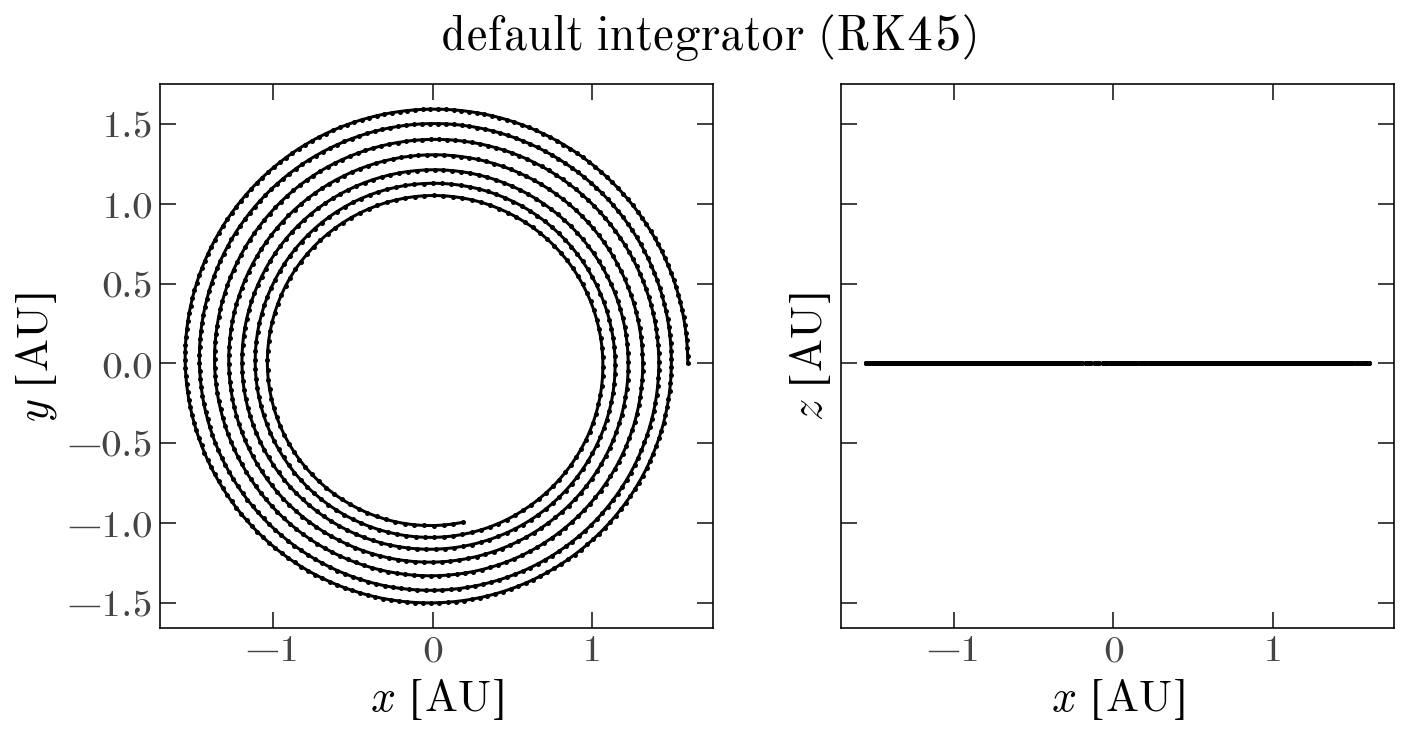

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(soln.y[0], soln.y[1])
axes[0].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{unitsys[0]:latex_inline}]')

# x-z
axes[1].plot(soln.y[0], soln.y[2])
axes[1].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{unitsys[0]:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')
    
fig.suptitle('default integrator (RK45)', fontsize=24)

The orbit is confined to the x-y plane, as we might expect (we only gave the particle velocity in the y direction, starting from the x axis). However: **that doesn't look like a circular orbit**: The orbit in the x-y plane looks more like a spiral!?! This is a telltale sign of energy drift. The force on our test particle is conservative and time-independent, so the orbital energy should be conserved along the particle's orbit. Let's compute the total energy for this numerically-integrated orbit and see if it is constant. To do that, we will implement a function to evaluate the point mass potential energy (defined above), and the total energy (the sum of potential and kinetic energy) at any phase-space position:

In [22]:
def ptmass_potential(xyz, M):
    """
    Compute the potential energy from a point mass at the given
    position(s) ``xyz``.
    
    Parameters
    ----------
    xyz : quantity-like
    M : quantity-like
    """
    r = np.sqrt(np.sum(xyz**2, axis=0))
    return - G * M / r


def ptmass_total_energy(w, M, unitsys):
    """
    Compute the total energy (kinetic + potential) for phase-space 
    position(s) ``w``.
    
    Parameters
    ----------
    w : array-like
    M : quantity-like
    unitsys : list, collection
        A list or iterable containing the base units that define the
        adopted unit system. Order: length, mass, time
    """
    xyz = w[:3] * unitsys[0]
    vxyz = w[3:] * unitsys[0] / unitsys[2]
    E_kin = 0.5 * np.sum(vxyz ** 2, axis=0)
    E_pot = ptmass_potential(xyz, M)
    return E_kin + E_pot

We can now compute the energy for each point in the orbital time series, and the fractional energy change relative to the initial energy `dE`:

Text(0.5, 0.98, 'default integrator (RK45)')

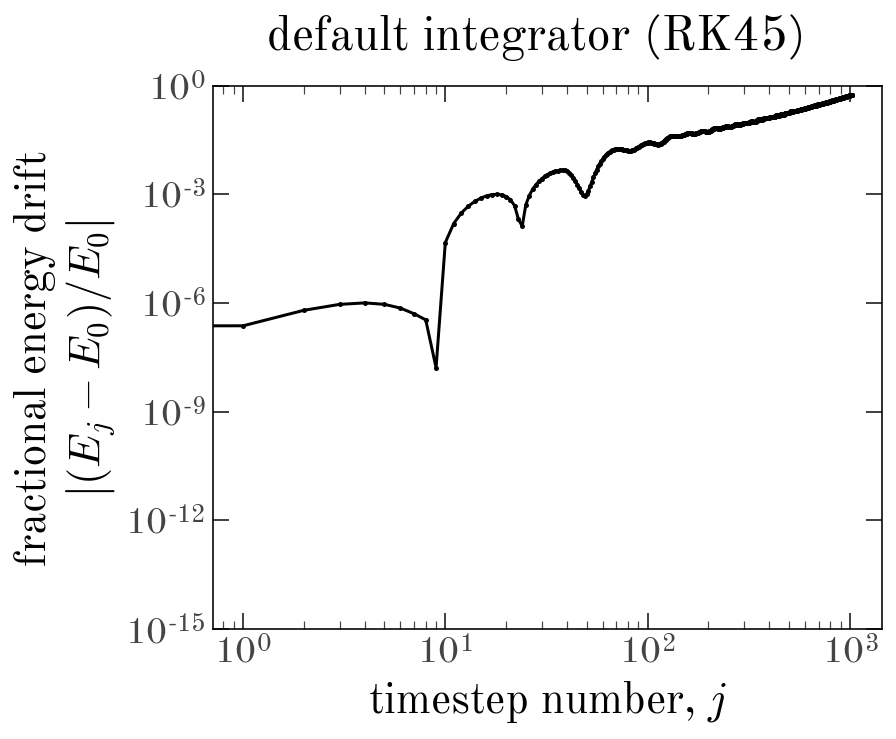

In [40]:
E = ptmass_total_energy(soln.y, M, unitsys)
dE = np.abs((E[1:] - E[0]) / E[0])

plt.figure(figsize=(6, 5))
plt.loglog(dE)
plt.xlabel('timestep number, $j$')
plt.ylabel('fractional energy drift\n' + r'$\left|(E_j - E_0) / E_0\right|$')
plt.ylim(1e-15, 1e0)
plt.suptitle('default integrator (RK45)', fontsize=24)

Aha! The energy of the computed orbit drifts steadily toward a nearly 100% change from the initial energy: This explains why the computed orbit does not look like a circular orbit, as we would expect. The fact that energy is not conserved is a consequence of the default integration method used by `solve_ivp()`: An (effectively) 4th-order Runge–Kutta method. Runge–Kutta methods are class of iterative schemes for computing approximate solutions for ordinary differential equations. However, they are approximate, and so these methods steadily accumulate errors. With `solve_ivp()`, we can control the error tolerance (the internal timestep used to perform the integration) using the function arguments `rtol` and `atol`, which set the threshold relative (rtol) and absolute (atol) error tolerances (see the [solve_ivp() documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for more context).

Let's try re-running the orbit calculation, but with much smaller `rtol` and `atol` values (compared to the defaults of 1e-3 and 1e-6, respectively):

In [24]:
soln_tol = solve_ivp(
    ptmass_F, 
    y0=w0, 
    args=(GM, ),
    t_span=(t_eval.min(), t_eval.max()), 
    t_eval=t_eval,
    rtol=1e-12,
    atol=1e-8
)

Text(0.5, 0.98, 'RK45 (improved tolerance)')

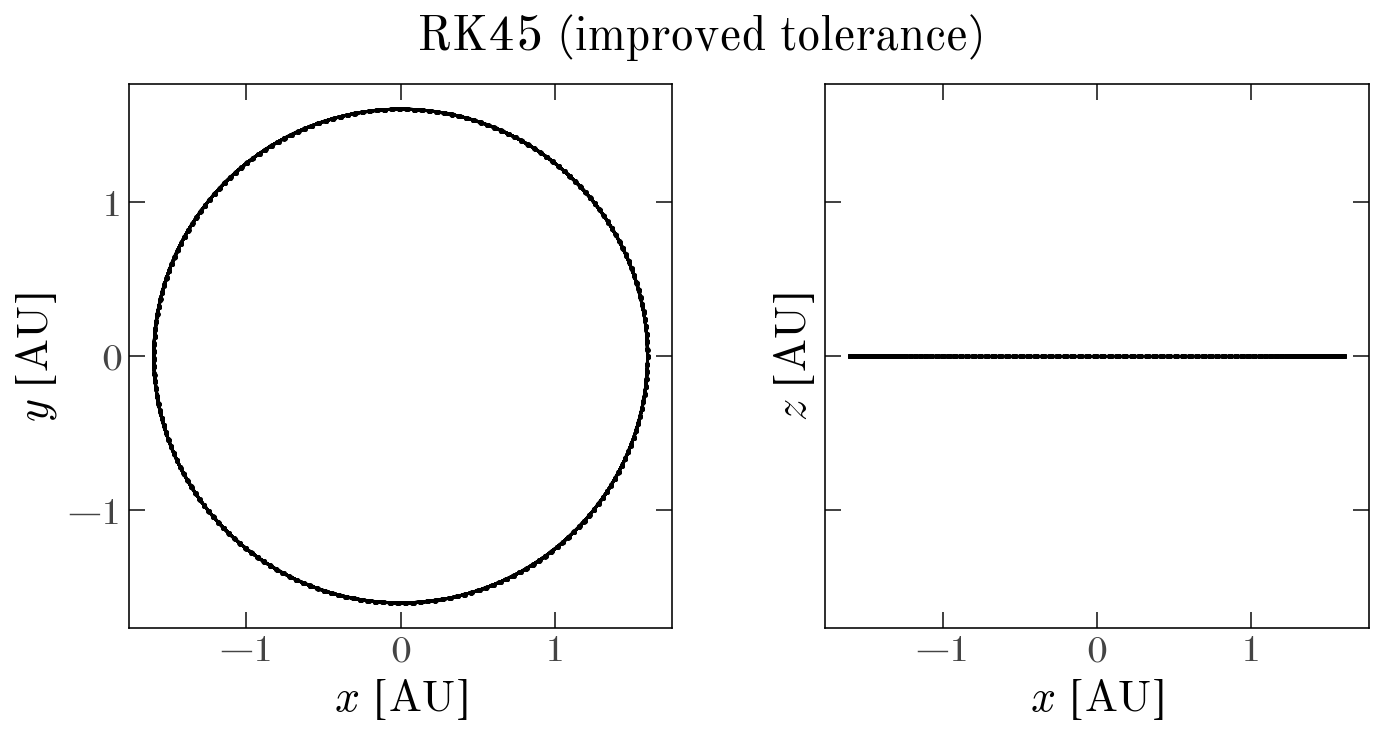

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(soln_tol.y[0], soln_tol.y[1])
axes[0].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{unitsys[0]:latex_inline}]')

# x-z
axes[1].plot(soln_tol.y[0], soln_tol.y[2])
axes[1].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{unitsys[0]:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')
    
fig.suptitle('RK45 (improved tolerance)', fontsize=24)

That looks much better! The orbit looks circular, and it visually appears to stay circular and planar for the duration of our integration window. 

We therefore expect the energy conservation to be preserved much more accurately for this case:

Text(0.5, 1.0, 'RK45 (improved tolerance)')

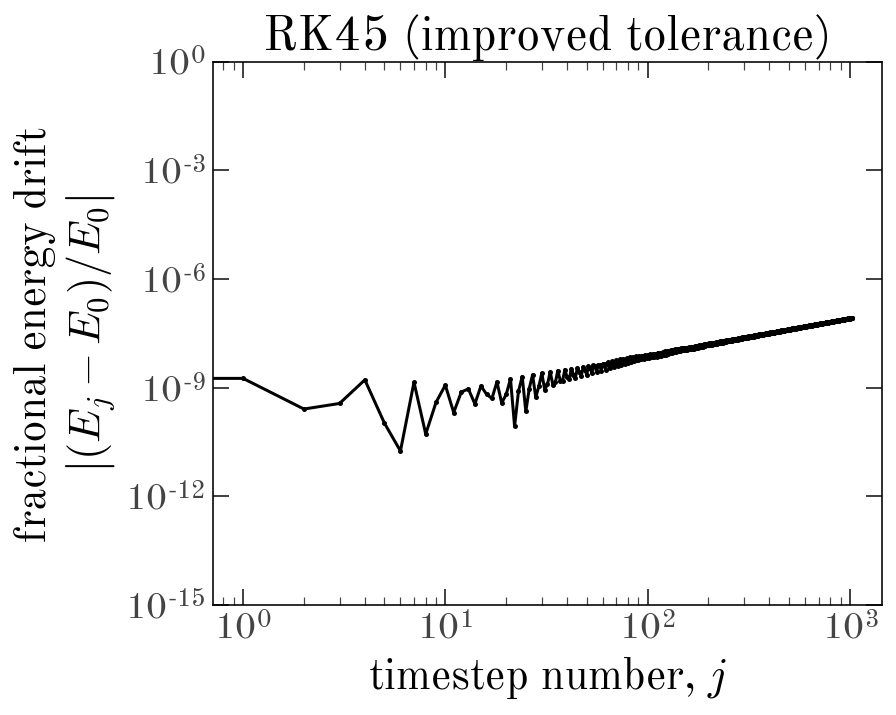

In [70]:
E = ptmass_total_energy(soln_tol.y, M, unitsys)
dE = np.abs((E[1:] - E[0]) / E[0])

plt.figure(figsize=(6, 5))
plt.loglog(dE)
plt.xlabel('timestep number, $j$')
plt.ylabel('fractional energy drift\n' + r'$\left|(E_j - E_0) / E_0\right|$')
plt.ylim(1e-15, 1e0)
plt.title('RK45 (improved tolerance)', fontsize=24)

Indeed, by the end of our integration window, the energy changes by $<10^{-7}$ relative to the initial energy for this case (the axis limits are the same here as in the previous plot! Scroll up to compare the two plots).

## Other Integration Algorithms

Runge–Kutta methods represent one class of numerical ODE integration tools, but there are several other classes of algorithms that are commonly used. Another class of algorithms that is used especially for evolving dynamical systems are *symplectic* integration methods. As we saw above with the Runge–Kutta scheme, over long times, errors introduced from approximations inherent to the method accumulate and lead to an increasing net change in the energy (which should be conserved). Symplectic integrators are special in that the iterative steps in the algorithm are *canonical transformations* themselves. A result of this is that, in conservative systems, over long times or averaged over time, these integrator classes conserve energy (in an average sense) and phase-space volume. In detail, the energy actually oscillates around the true energy, but it does not diverge from approximations in the method and only drifts due to numerical precision, which happens over much longer (integration) timescales.

One of the most well-known symplectic integration methods is the [*Leapfrog algorithm*](https://en.wikipedia.org/wiki/Leapfrog_integration), which is a specific type of more general Verlet integration schemes. Leapfrog is a 2nd-order method (the truncation error is 2nd-order) meaning that at fixed timestep, it will not be as precise as, for example, a 5th-order Runge–Kutta scheme. However, the approximate stability of the energy and the conserved phase volume is often desirable for long integrations. There are also 3rd, 4th, and higher-order analogs to Leapfrog integration that have better error properties (at fixed timestep) over short timescales.


### Leapfrog Integration

The default algorithm for Leapfrog integration advances the position and velocity (momentum) coordinates separately, and out of sync by 1/2 of a timestep, hence the "leapfrog" in the name: When the velocity advances by a full step from (timestep $i - \frac{1}{2}$) to (timestep $i + \frac{1}{2}$), it "leapfrogs" over the position (at timestep $i$). In a bit more detail, Leapfrog works as follows, starting from initial conditions $\boldsymbol{x}_0$ and $\boldsymbol{v}_0$ at time $t=t_0$:

- Compute the acceleration on the particle at the initial time:

  $$
  \boldsymbol{a}(t_0) = -\nabla \Phi|_{\boldsymbol{x}_0}
  $$
  
- Advance the velocity by 1/2 of a timestep $h=\Delta t$:

  $$
  \boldsymbol{v}_{1/2} = \boldsymbol{v}_0 + \frac{h}{2}\,\boldsymbol{a}(t_0)
  $$
  
- For each timestep $i$: 

    - Increment the position by a full timestep using the "old" velocity, $\boldsymbol{v}_{i - 1/2}$
    
      $$
      \boldsymbol{x}_{i} = \boldsymbol{x}_{i-1} + h\,\boldsymbol{v}_{i - 1/2}
      $$
    
    - Compute the acceleration at the "new" position:
    
      $$
      \boldsymbol{a}(t_i) = -\nabla \Phi|_{\boldsymbol{x}_i}
      $$
      
    - Increment the velocity by a full timestep using the "new" acceleration
    
      $$
      \boldsymbol{v}_{i+1/2} = \boldsymbol{v}_{i-1/2} + h\,\boldsymbol{a}(t_i)
      $$
      
      
One caveat is that, if we stored all of the positions $\boldsymbol{x}_{i}$ and velocities $\boldsymbol{v}_{i+1/2}$, they would be out of sync with one another. In practice, it is common to instead split the velocity timestep increment into two increments by half of a timestep, so the last step in each iteration would look like:

- Increment the velocity by two half timesteps using the "new" acceleration
  $$
  \boldsymbol{v}_{i} = \boldsymbol{v}_{i-1/2} + \frac{h}{2}\,\boldsymbol{a}(t_i)
  \boldsymbol{v}_{i+1/2} = \boldsymbol{v}_{i} + \frac{h}{2}\,\boldsymbol{a}(t_i)
  $$
  
where we then save the (synchronized) $\boldsymbol{x}_{i}$ and $\boldsymbol{v}_{i}$ values as the orbital time series.

Let's implement this algorithm as a function, like `solve_ivp()`, which itself takes a function that computes the acceleration as the argument `acc_func`, along with initial conditions `x0` and `v0`, a timestep `dt`, and a number of timesteps `n_steps`. Because we are implementing this ourselves, we can build in support for Astropy units:

In [50]:
def leapfrog_integrate(acc_func, x0, v0, dt, n_steps, acc_func_args=()):
    """
    Parameters
    ----------
    acc_func : callable
        A function that computes the acceleration at a position.
    x0 : quantity-like [length]
        Initial position.
    v0 : quantity-like [velocity]
        Initial velocity.
    dt : quantity-like [time]
        Timestep.
    n_steps : int
        The number of timesteps to take.
    acc_func_args : iterable, list (optional)
        Any additional arguments to be passed to the `acc_func` function.
    """
    # Make sure the input initial conditions and timestep are valid:
    x0 = u.Quantity(x0)
    v0 = u.Quantity(v0)
    ts = u.Quantity(dt) * np.arange(int(n_steps) + 1)
    
    # Initialize the velocity: step forward by 1/2 timestep
    a0 = acc_func(x0, *acc_func_args)
    v_1_2 = v0 + a0 * dt / 2.
    
    # Set up array Quantity objects to store the full orbits for both 
    # position and velocity
    xs = np.full((3, len(ts)), np.nan) * x0.unit
    xs[:, 0] = x0
    vs = np.full((3, len(ts)), np.nan) * v0.unit
    vs[:, 0] = v0
    
    x_im1 = x0
    v_im1_2 = v_1_2
    for i in range(n_steps):
        x_i = x_im1 + v_im1_2 * dt
        a_i = acc_func(x_i, *acc_func_args)

        v_i = v_im1_2 + a_i * dt / 2
        v_ip1_2 = v_i + a_i * dt / 2
        
        xs[:, i + 1] = x_i
        vs[:, i + 1] = v_i
        
        x_im1 = x_i 
        v_im1_2 = v_ip1_2
        
    return ts, xs, vs

We can now compute the same orbit, using the same point mass potential and initial conditions as above. We will compute it for many more timesteps to compare the long-term behavior of Leapfrog with the Runge–Kutta schemes used above (this takes about 15 seconds on my machine - it is much slower because operations are slower with astropy Quantities as compared to numpy arrays - ask me about how we could speed this up if you are curious!):

In [56]:
lf_ts, lf_xs, lf_vs = leapfrog_integrate(
    ptmass_acceleration, 
    x0, 
    v0,
    dt=1 * u.day,
    n_steps=16384,
    acc_func_args=(M, )
)

Let's now plot the same projections of the positional components of the orbit to compare with the plots above:

Text(0.5, 0.98, 'Leapfrog')

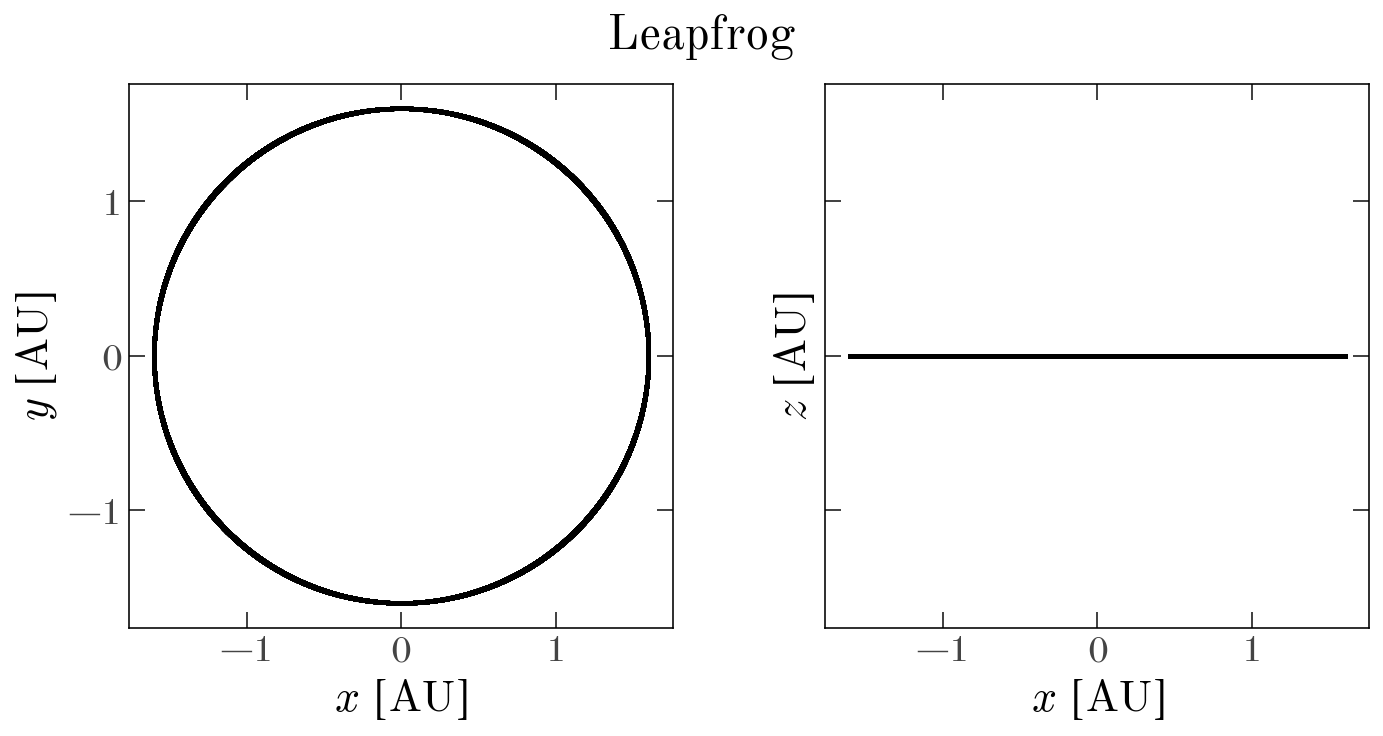

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(lf_xs[0], lf_xs[1])
axes[0].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{unitsys[0]:latex_inline}]')

# x-z
axes[1].plot(lf_xs[0], lf_xs[2])
axes[1].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{unitsys[0]:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')
    
fig.suptitle('Leapfrog', fontsize=24)

This looks like the same circular orbit that we computed above! How well does it conserve energy?

Text(0.5, 1.0, 'Leapfrog')

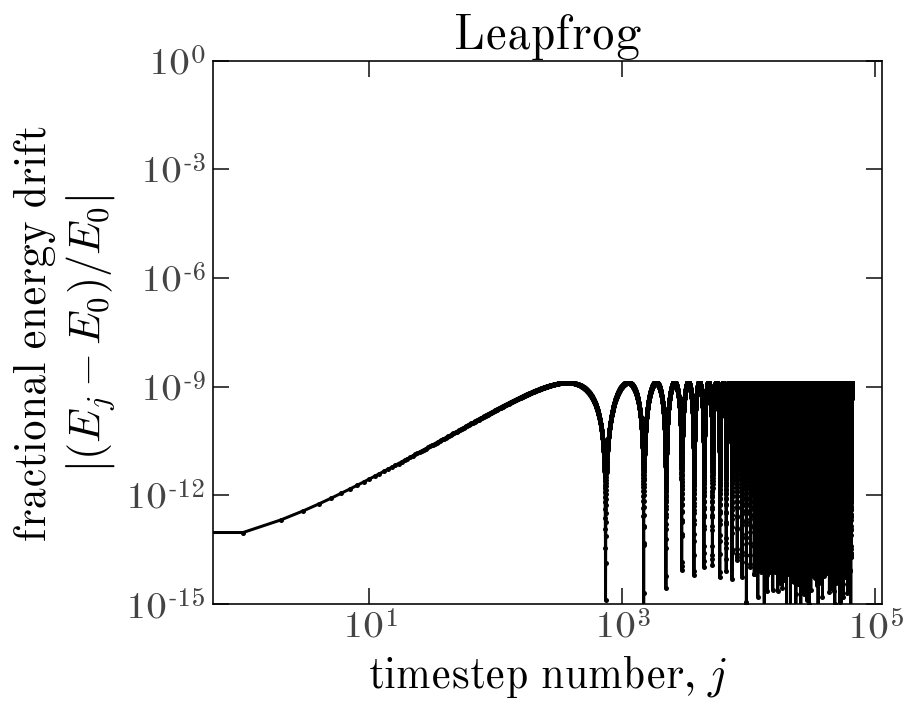

In [71]:
E = ptmass_potential(lf_xs, M) + 0.5 * np.sum(lf_vs**2, axis=0)
E = E.decompose(unitsys)
dE = np.abs((E[1:] - E[0]) / E[0])

plt.figure(figsize=(6, 5))
plt.loglog(dE)
plt.xlabel('timestep number, $j$')
plt.ylabel('fractional energy drift\n' + r'$\left|(E_j - E_0) / E_0\right|$')
plt.ylim(1e-15, 1e0)
plt.title('Leapfrog', fontsize=24)

Interestingly, as we expect, the error conservation is different: Rather than steadily rising toward larger numbers of timesteps (compare to the two equivalent figures above), the energy here is not constant, but appears to oscillate around a constant value. We can see this clearer by plotting the energy difference from the mean on a linear-linear plot:

(0.0, 10000.0)

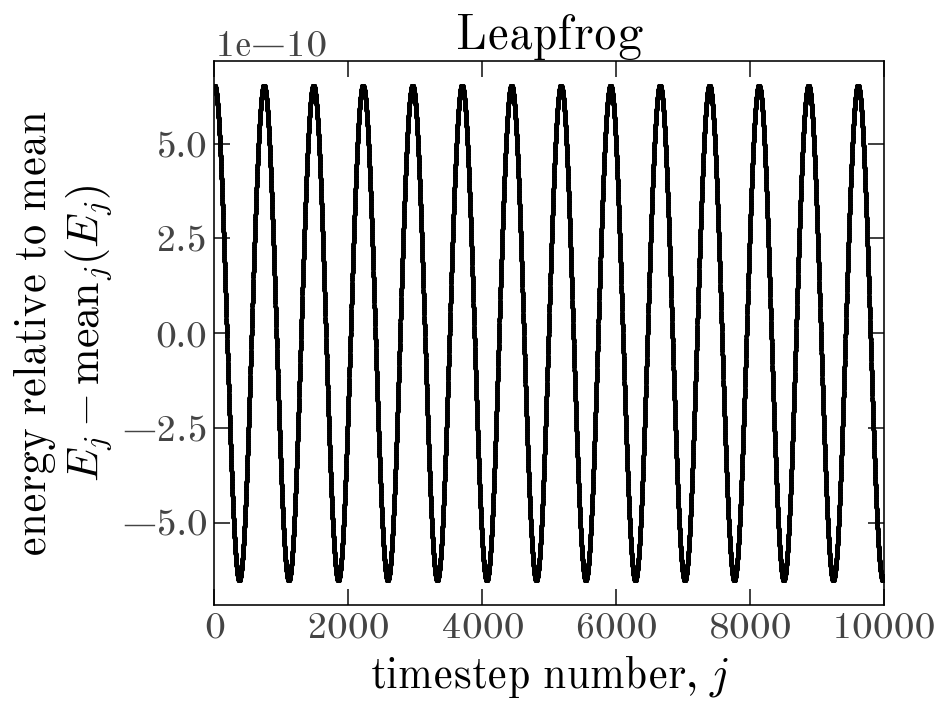

In [73]:
plt.figure(figsize=(6, 5))
mean_E = np.mean(E)
plt.plot((E - mean_E) / mean_E)
plt.xlabel('timestep number, $j$')
plt.ylabel('energy relative to mean\n' + r'$E_j - {\rm mean}_j(E_j)$')
plt.title('Leapfrog', fontsize=24)
plt.xlim(0, 10000)

The oscillations of the energy are small (on the order of $10^{-10}$ fractional changes in the energy), and appear more or less stable over the timescale that we integrated this orbit over.

We hope that this comparison of Runge–Kutta and Leapfrog methods for the point mass potential gives you a sense that there are often many tools for the job of numerical orbit computation. But which integration scheme should you use? In many contexts in Galactic dynamics, it doesn't make much of a difference: As long as your timestep is small enough that you conserve energy with enough precision for the problem at hand, you can use any of these integration schemes. However, for some problems it may be important to more precisely conserve phase-volume, in which case symplectic integrators are often a safer choice.

In practice, while it is fine to build your own machinery to do orbit integration, there are several tools available for Galactic dynamics that do a lot of the heavy lifting for you (and do it fast!). For example, in Python, your options are:

- [Gala](http://gala.adrian.pw/)
- [Galpy](https://github.com/jobovy/galpy)
- [Agama](http://agama.software/)

most of which implement the integration methods mentioned here (and others!), along with many of the gravitational potential models that we will discuss in the next few sections and tutorials.

### Exercise: Varying the initial conditions

So far, we have only worked with initial conditions for a circular orbit. Compute a for more orbits using `leapfrog_integrate()`, but with different choices for initial conditions (e.g., try different y velocity values, or try generating random velocity vectors). What do generic orbits look like?

## The Plummer Potential

The Kepler potential is special because it represents a point mass, i.e. the density distribution is infinite at its origin and zero everywhere else. Most mass distributions that are relevant for Galactic dynamics are well-represented by density distributions that are finite everywhere or throughout some enclosed volume.

Mathematically, one of the simplest spherical extended (non-point) mass distributions is the [Plummer Sphere](https://en.wikipedia.org/wiki/Plummer_model), given by the potential:

$$
\Phi(r) = - \frac{G \, M}{\sqrt{r^2 + b^2}}
$$

### Exercise: What is the Plummer density distribution?

Using Poisson's equation, the density is related to the Laplacian of the potential such that:

$$
\rho(r) = (4\pi\,G)^{-1} \, \nabla^2 \Phi
$$

Using the spherical expression of the potential, we must take the spherical Laplacian (but the $\partial \phi$ and $\partial \theta$ terms are zero):

$$
\begin{align}
\nabla^2 \Phi(r) &= \frac{1}{r^2} \, \frac{\partial \Phi}{\partial r}\left( r^2 \, \frac{\partial \Phi}{\partial r} \right)\\
&= \frac{1}{r^2} \, \frac{\partial \Phi}{\partial r}\left( \frac{G\,M\,r^3}{(r^2 + b^2)^{3/2}} \right)\\
\rho(r) &= \frac{M}{\frac{4}{3}\pi\,b^3} \, \left(\frac{r^2}{b^2} + 1\right)^{-5/2}
\end{align}
$$

Proof with `sympy`:

In [102]:
_G, _M, _b, _r = sy.symbols('G, M, b, r', real=True, positive=True)

In [110]:
plummer_Phi = - _G * _M / sy.sqrt(_r**2 + _b**2)
plummer_Phi

-G*M/sqrt(b**2 + r**2)

In [111]:
plummer_d2_Phi = sy.simplify(
    1/_r**2 * sy.diff(_r**2 * sy.diff(plummer_Phi, _r), _r))

In [112]:
plummer_dens = plummer_d2_Phi / (4*sy.pi * _G)
plummer_dens

3*M*b**2/(4*pi*(b**2 + r**2)**(5/2))

### Mass enclosed: Circular velocity in extended mass distributions?

Above, we saw how to compute the circular velocity of an orbit at radius $r$ in the point mass potential. This concept works in any spherical, central potential model, even when the mass is extended, such as in the case of the Plummer model. In more general spherical mass models, the equation for the circular velocity in terms of a derivative of the potential is still valid:

$$
v_{\rm circ}(r) = \sqrt{r \, \left|\frac{\textrm{d}\Phi}{\textrm{d}r}\right|}
$$

However, an alternate way of computing the circular velocity is to use the *mass enclosed* $M(<r)$, which specifies the mass enclosed within a radius $r$ and is defined as:

$$
M(<r) = \int^r_0 \textrm{d}\tilde{r} \, 4\pi\,\tilde{r}^2 \, \rho(\tilde{r})
$$

With the mass enclosed, the circular velocity can also be computed as:

$$
v_{\rm circ}(r) = \sqrt{\frac{G\,M(<r)}{r}}
$$

### Exercise: Implement the Plummer Potential and Compute a Circular Orbit

**First, derive an expression for the mass enclosed in the Plummer model**

*Solution:*

You can either take the derivative of the potential and compute the mass enclosed using the radial derivative of the potential, or compute the integral of the mass density given above. Here, we will use `sympy` to do both. First, using the derivative:

In [119]:
sy.simplify(sy.sqrt(_r * sy.diff(plummer_Phi, _r)))

sqrt(G)*sqrt(M)*r/(b**2 + r**2)**(3/4)

In [115]:
plummer_Menc = sy.integrate(4*sy.pi * _r**2 * plummer_dens, _r)
sy.simplify(sy.sqrt(_G * plummer_Menc / _r))

sqrt(G)*sqrt(M)*r/(b**2 + r**2)**(3/4)

**Next, implement a function to evaluate the circular velocity in the Plummer potential**

*Solution:*

In [124]:
def plummer_vcirc(r, M, b):
    return np.sqrt(G * M) * r / (r**2 + b**2)**(3/4)

**Now implement an acceleration function for the Plummer model:**

*Solution:* 

First we have to work out the Cartesian gradient of the potential. For the $x$ term, this is equivalent to:

$$
\begin{align}
\frac{\partial\Phi}{\partial r} &= \frac{G\,M\,r}{(r^2 + b^2)^{3/2}}\\
\frac{\partial\Phi}{\partial x} &= \frac{\partial\Phi}{\partial r} \, \frac{\partial r}{\partial x}\\
&= \frac{\partial\Phi}{\partial r} \, \frac{x}{r}\\
&= \frac{G\,M\,x}{(r^2 + b^2)^{3/2}}
\end{align}
$$

so the $y$ and $z$ terms will be the same, with $x$ swapped out for each respective coordinate value.

In [126]:
def plummer_acceleration(xyz, M, b):
    """    
    Parameters
    ----------
    xyz : quantity-like
        This should have shape (3, ...)
    M : quantity-like
        The total mass.
    b : quantity-like
        The scale radius.
    
    """
    r2 = np.sum(xyz**2, axis=0)
    dPhi_dr = G * M / (r2 + b**2) ** 1.5
    return - dPhi_dr * xyz

**Finally, compute a circular orbit starting at $(x, y, z) = (5, 0, 0)~\textrm{pc}$ (i.e. $r_0 = 5~\textrm{pc}$) using `leapfrog_integrate()` with the Plummer acceleration function you implemented, adopting the parameter values** $M=10^7~\textrm{M}_\odot$ and $b = 8~\textrm{pc}$

Think about what a good order of magnitude would be for the timestep (*Hint: what is $2\pi\,r_0 / v_\textrm{circ}$?*\)

In [130]:
r0 = 5 * u.pc
x0 = [1, 0, 0] * r0

plummer_M = 1e7 * u.Msun
plummer_b = 8 * u.pc
vcirc = plummer_vcirc(r0, plummer_M, plummer_b)
print(vcirc.to(u.km/u.s))

v0 = [0, 1, 0] * vcirc

35.78557862000943 km / s


In [132]:
dt = 2*np.pi*r0 / vcirc / 256  # 256 steps per orbital period
dt.to(u.Myr)

<Quantity 0.00335311 Myr>

In [133]:
plummer_ts, plummer_xs, plummer_vs = leapfrog_integrate(
    plummer_acceleration, 
    x0=x0,
    v0=v0,
    dt=dt,
    n_steps=1024,
    acc_func_args=(plummer_M, plummer_b)
)

**Plot the orbit in x-y and x-z projections:**

Text(0.5, 0.98, 'Circular orbit in the Plummer model')

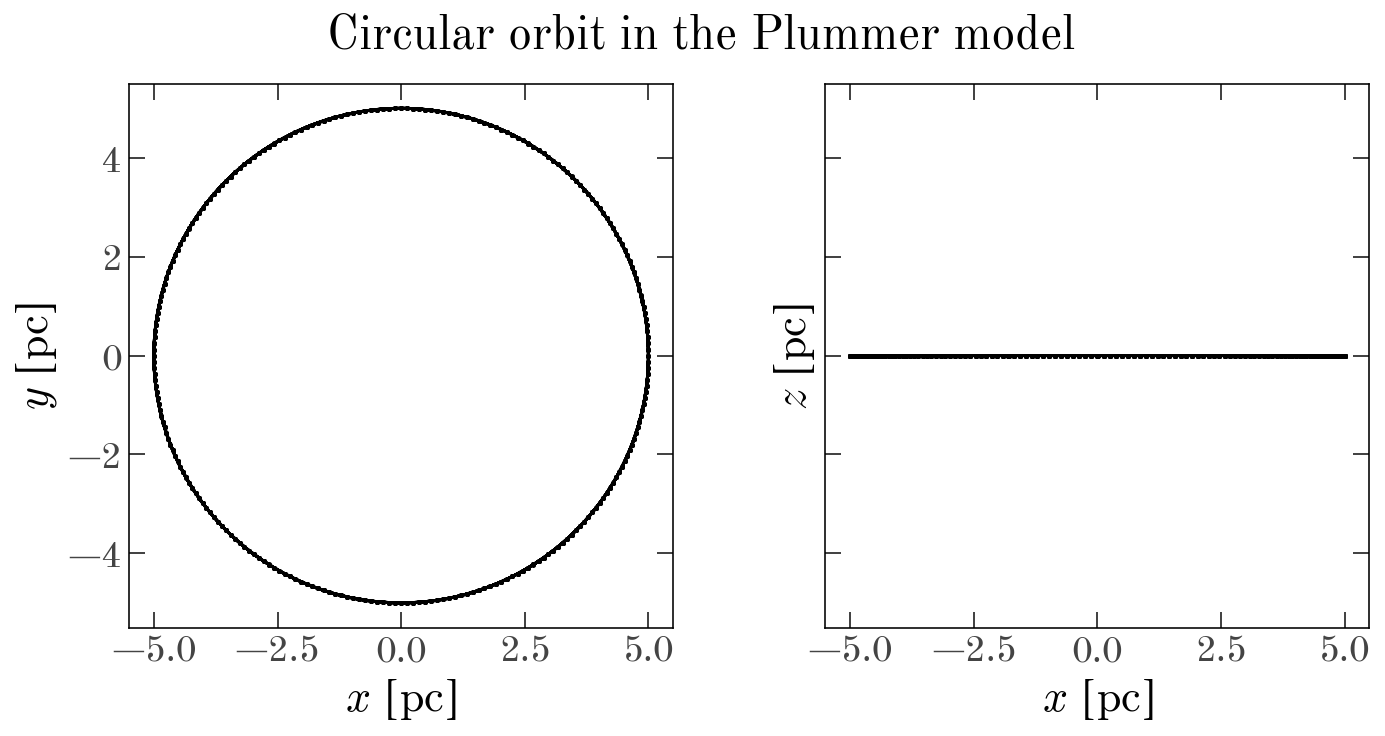

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(plummer_xs[0], plummer_xs[1])
axes[0].set_xlabel(f'$x$ [{plummer_xs.unit:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{plummer_xs.unit:latex_inline}]')

# x-z
axes[1].plot(plummer_xs[0], plummer_xs[2])
axes[1].set_xlabel(f'$x$ [{plummer_xs.unit:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{plummer_xs.unit:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')
    
fig.suptitle('Circular orbit in the Plummer model', fontsize=24)

**Compute a few other random bound orbits in the Plummer model (using small, random velocity offsets from the circular orbit initial conditions). How are these orbits different from the orbits in the point mass potential?**

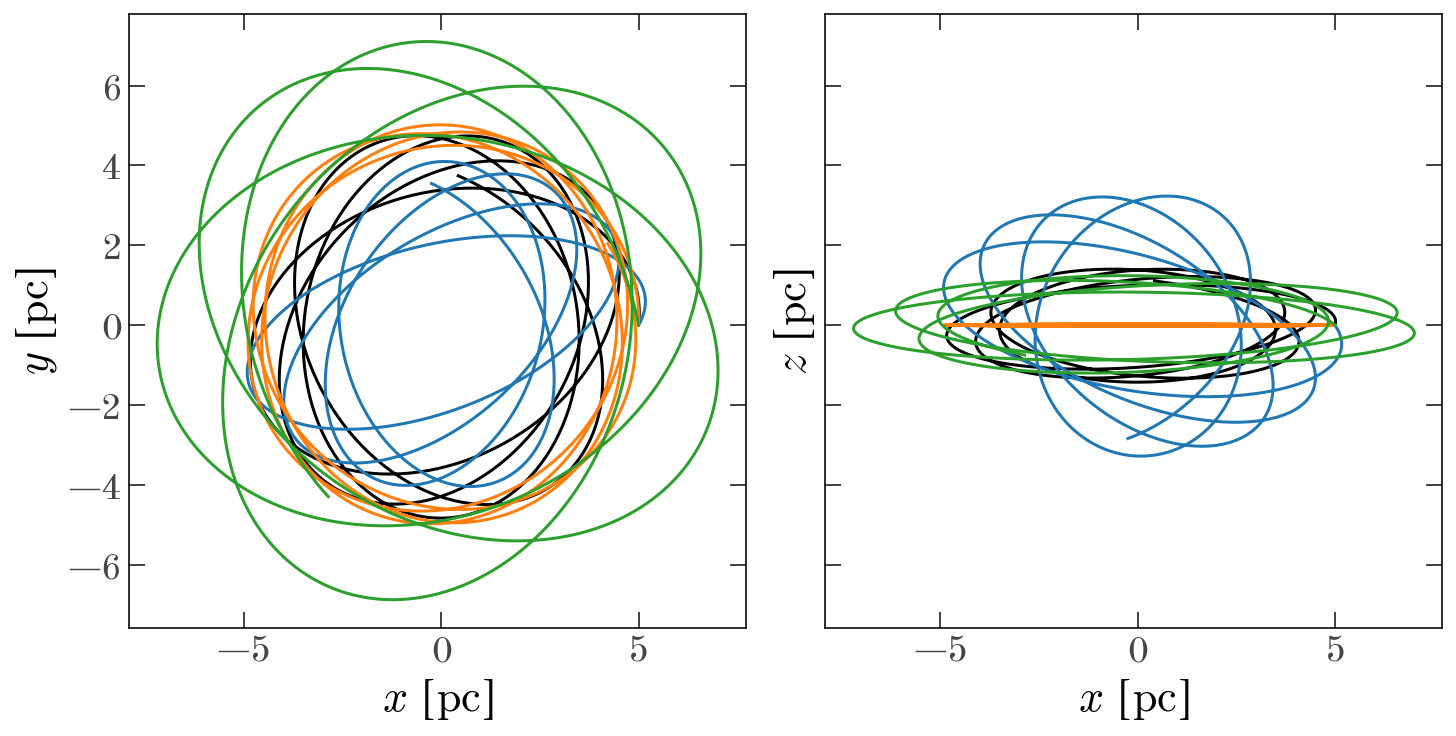

In [141]:
rng = np.random.default_rng(seed=42)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

axes[0].set_xlabel(f'$x$ [{plummer_xs.unit:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{plummer_xs.unit:latex_inline}]')

axes[1].set_xlabel(f'$x$ [{plummer_xs.unit:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{plummer_xs.unit:latex_inline}]')

for n in range(4):    
    this_plummer_ts, this_plummer_xs, this_plummer_vs = leapfrog_integrate(
        plummer_acceleration, 
        x0=x0,
        v0=v0 + rng.normal(0, 10, size=3) * u.km/u.s,
        dt=dt,
        n_steps=1024,
        acc_func_args=(plummer_M, plummer_b)
    )
    
    axes[0].plot(this_plummer_xs[0], this_plummer_xs[1], marker='')
    axes[1].plot(this_plummer_xs[0], this_plummer_xs[2], marker='')

Generic orbits in the Plummer model (and any extended spherical mass distribution) are unlike orbits in the point mass potential: In the point mass model, orbits form closed (Keplerian) ellipses, whereas in generic spherical mass models, orbits are *not* closed and instead trace our "rosette" patterns. One property that all orbits in spherical mass models share (including orbits in the point mass model, Plummer model, and any other) is that they are confined to a plane. That plane can be oriented with any arbitrary angles with respect to the adopted coordinate system, but a fundamental property of orbits in spherical mass models is that the motion can be reduced to 2D planar motion with a suitable choice of coordinate system. This is *not* true in more complex mass models (e.g., axisymmetric/disky, triaxial models, or more realistic models of dark matter distributions in galaxies); so why is this the case in spherical models?

## Integrals and Constants of Motion

TODO:
- Planar motion in spherical models related to integrals of motion
- what are they
- Energy, already saw
- angular momentum also conserved for any choice of initial conditions
- more generically: any integral that satisfies...

We saw above that for generic orbits in time-independent gravitational fields, the total energy is conserved or constant at any point along the orbit. Depending on the symmetries of the mass distribution, orbits generically also have other conserved quantities, which are either *constants of motion* (functions of the phase-space coordinates and time, $C_C(\boldsymbol{x}, \boldsymbol{v}, t)$, that are constant along an orbit) and/or *integrals of motion* (functions of the phase-space coordinates only, $C_I(\boldsymbol{x}, \boldsymbol{v})$, that are constant along an orbit). The energy is an example of a constant of motion; In a spherical, time-independent mass distribution, orbits also have 3 other integrals of motion: The three components of the angular momentum vector $L_x, L_y, L_z$. The fact that orbits in spherical models have four constants of motion in 6D phase-space means that the orbits are confined to a 2D sub-space: The orbits should therefore be planar! There are deep connections between coordinate symmetries, constants of motion, and the geometry of orbits.

TODO: show that angular momentum components also close to constant

In [159]:
rng = np.random.default_rng(seed=123)

plummer_ts, plummer_xs, plummer_vs = leapfrog_integrate(
    plummer_acceleration, 
    x0=x0 + rng.normal(0, 5, size=3) * u.pc,
    v0=v0 + rng.normal(0, 20, size=3) * u.km/u.s,
    dt=dt,
    n_steps=1024,
    acc_func_args=(plummer_M, plummer_b)
)

In [160]:
L = np.cross(plummer_xs, plummer_vs, axis=0)
L = L.to(u.km/u.s * u.pc)

In [162]:
L

<Quantity [[-370.18972275, -370.18972275, -370.18972275, ...,
            -370.18972275, -370.18972275, -370.18972275],
           [  24.35464445,   24.35464445,   24.35464445, ...,
              24.35464445,   24.35464445,   24.35464445],
           [  10.08170103,   10.08170103,   10.08170103, ...,
              10.08170103,   10.08170103,   10.08170103]] km pc / s>

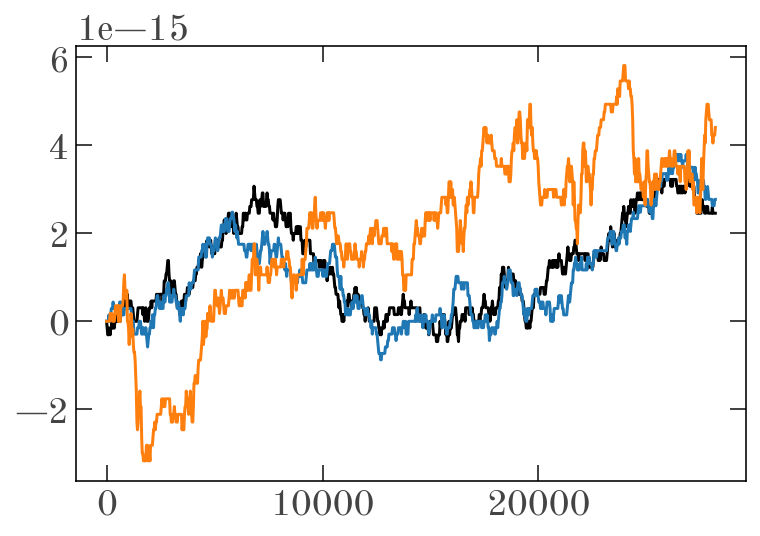

In [166]:
for i in range(3):
    plt.plot(plummer_ts, (L[i] - L[i, 0]) / L[i, 0], marker='')

## Other Common Spherical Potentials

TODO:
- Introduce Gala
- Demonstrate orbit integration with Gala
- Introduce other common spherical models
    - NFW
    - Hernquist
    - General power law or two-power

## Orbits in General Spherical Models

TODO:
- Closed vs. non-closed
- Make a gallery showing orbit in each model introduced
- Frequencies (radial and azimuthal)
- Precession of apocenters